In [ ]:
import os
import tensorflow as tf
# import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib
from tensorflow.keras import Sequential,layers,Input,optimizers,utils,callbacks,metrics,regularizers,models
from tensorflow.keras.applications import EfficientNetB0,ResNet50V2,EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input


# 1. Preprocessing Pipeline

In [ ]:
!ls

drive  sample_data


In [ ]:
# raw_data_path = '../raw_data'
merged_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download latest version
def dataset_download(raw_data_path):
    print("We are downloading raw datasets....")
    print("-" * 40)
    raw_data_path = "../raw_data"
    if os.path.exists(raw_data_path) and len(os.listdir(raw_data_path)) > 1:
        print(f'Datasets already downloaded ')
    else:
        kaggle.api.dataset_download_files(
            "yangsangtai/tiny-genimage",
            path="../raw_data",
            unzip=True
        )
    print("-" * 40)

In [ ]:
# get datasets
def get_available_datasets(raw_data_path):
    print("We are getting available datasets.....")
    print("-" * 40)
    datasets = os.listdir(raw_data_path)
    available_datasets = []
    for dataset in datasets:
        train_path= os.path.join(raw_data_path,dataset,"train")
        if os.path.exists(train_path):
            available_datasets.append(dataset)
        else:
            print(f"{dataset} is available")


    print(f"There are {len(available_datasets)} datasets available.")
    print(f"they are {available_datasets}")
    print(f'Done')
    print("-" * 40)
    return available_datasets


In [ ]:
available_datasets = get_available_datasets(raw_data_path=raw_data_path)

NameError: name 'raw_data_path' is not defined

In [ ]:
# step 1 : check if pictures are valid
def check_image_valid(image_path):
    try:
        img = Image.open(image_path)
        # check if the image is valid
        img.verify()
        img = Image.open(image_path)
        # convert image to RGB
        img = img.convert(mode="RGB")
        # check the size of image
        width,height = img.size
        if width <32 or height <32:
            print(f"This picture :{image_path} is too small")
            return False
        # check the content of image
        img_array = np.array(img)
        if np.std(img_array)<1 :
            print(f"This picture :{image_path} has no content")
            return False
        return True
    except Exception as e:
        print(str(e))
        return False


In [ ]:
# step 2 : clean the raw datasets
def clean_one_dataset(base_path,dataset_name):

    stats = {
    "total": 0,
    "valid" : 0,
    "invalid": 0,
    'removed': []
    }
    dataset_path = os.path.join(base_path,dataset_name)

    for split in ['train','val']:
        split_path = os.path.join(dataset_path,split)
        if not os.path.exists(split_path):
            continue
        for class_name in ['ai','nature']:
            class_path = os.path.join(split_path,class_name)
            if not os.path.exists(class_path):
                continue
            print(f"We are checking {dataset_path}/{split}/{class_name}")

            # check all the pictures of current directory

            image_files = [f for f in os.listdir(class_path)]

            for image_file in image_files:
                image_path = os.path.join(class_path,image_file)
                stats['total']+=1
                status = check_image_valid(image_path)
                if status == True:
                    stats['valid'] +=1
                else:
                    stats['invalid']+=1
                    stats['removed'].append(f"{image_file}")
                    try:
                        os.remove(image_path)
                        print(f"{image_path} is invalid")
                    except Exception as e:
                        print(f"{image_path} cannot be removed")

    print(f"Stats for {dataset_name}:")
    print(f"There are total {stats['total']} pictures")
    print(f"There are {stats['valid']} valid pictures")
    print(f"There are {stats['invalid']} invalid pictures")
    return stats

In [ ]:
def clean_all_datasets(raw_data_path,available_datasets):
    print("We are cleaning all datasets....")
    print("-" * 40)
    all_stats = {}
    for dataset in available_datasets:
        all_stats[dataset] = clean_one_dataset(raw_data_path,dataset)
    print("Done!")
    print("-" * 40)

In [ ]:
def get_image_hash(image_path):
    """
    Calculate the hash value
    """
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

In [ ]:
 # step 3 : Remove duplicates picture
def remove_duplicates(available_datasets,raw_data_path):
    print("we are removing duplicates......")
    print("-" * 40)
    # step 3 : Remove duplicates picture
    seen_hash = {}
    duplicates = []
    for dataset in available_datasets:
        dataset_path = os.path.join(raw_data_path, dataset)
        print(dataset_path)
        if not os.path.exists(dataset_path):
            continue
        for split in ["train", "val"]:
            for class_name in ["ai", "nature"]:
                class_path = os.path.join(dataset_path, split, class_name)
                if not os.path.exists(class_path):
                    continue
                for img_file in os.listdir(class_path):
                    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        continue
                    image_path = os.path.join(class_path, img_file)
                    image_hash = get_image_hash(image_path)
                    if image_hash is None:
                        print(f"Skip (no hash): {image_path}")
                        continue
                    if image_hash in seen_hash:
                        duplicates.append((image_path, seen_hash[image_hash]))
                        try:
                            os.remove(image_path)
                            print(f"Removed duplicate: {image_path} (same as {seen_hash[image_hash]})")
                        except Exception as e:
                            print(f"Cannot remove {image_path}: {e}")
                    else:
                        seen_hash[image_hash] = image_path

    print(f"Total duplicates removed/found: {len(duplicates)}")
    for dup, orig in duplicates[:20]:
        print(f"{dup} -> {orig}")
    print("Done!")
    print("-" * 40)

In [ ]:
# step 4 : Merge cleanned dataset to a new folder
def merge_clean_datasets(dataset,raw_data_path,target_path):

    stats = {
    'train':{'ai':0, 'nature':0},
    'val':{'ai':0,'nature':0}
    }
    # create the directories
    merged_train_path = os.path.join(merged_path, 'train')
    merged_val_path = os.path.join(merged_path, 'val')

    for split in ['train', 'val']:
        for class_name in ['ai', 'nature']:
            os.makedirs(os.path.join(merged_path, split, class_name), exist_ok=True)

    for dataset in available_datasets:
        dataset_path = os.path.join(raw_data_path,dataset)
        if not os.path.exists(dataset_path):
            continue
        for split in ['train','val']:
            split_path = os.path.join(dataset_path,split)
            if not os.path.exists(split_path):
                continue
            for class_name in ['ai','nature']:
                class_path = os.path.join(split_path,class_name)
                if not os.path.exists(class_path):
                    continue

                target_path = os.path.join(merged_path,split,class_name)
                copied = 0
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file,dst_file)
                        copied += 1
                        stats[split][class_name] += 1
    print(stats)
    return stats

In [ ]:
# merge datasets to target directory
def merge_all(raw_data_path,merged_path):
    print("We are merging raw datasets to target path")
    for dataset in available_datasets:
        merge_clean_datasets(dataset,raw_data_path,target_path=merged_path)
    print("Merge done!")
    print("="*40)

In [ ]:
# step 5 : Load dataset
def datasets_split(dataset_path, test_split,batch_size: int,img_size:tuple[int,int]):
    print("We are split datasets to train, val and test")
    print("-" * 40)
    merged_train_path = os.path.join(dataset_path,"train")
    merged_val_path = os.path.join(dataset_path,"val")

    train_ds = tf.keras.utils.image_dataset_from_directory(
    merged_train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['nature', 'ai'],
    seed=42

    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
    merged_val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['nature', 'ai'],
    seed=42
    )

    total_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    val_batches = tf.data.experimental.cardinality(val_ds).numpy()
    # Split test_ds from val_ds to avoid data leakage
    test_batches = int(val_batches * test_split)
    val_batches_final = val_batches - test_batches
    val_ds_shuffled = val_ds.shuffle(buffer_size=val_batches)
    test_ds = val_ds_shuffled.take(test_batches)
    val_ds = val_ds_shuffled.skip(test_batches)

    print(f"Total batches: {total_train_batches+val_batches}")
    print(f"Train batches: {total_train_batches}")
    print(f"Validation batches: {val_batches_final}")
    print(f"Test batches: {test_batches}")
    print("Split Done! and datasets are ready to feed the model")
    print('=' * 40 )

    return train_ds, val_ds, test_ds

In [ ]:
def datasets_prefetch(train_ds,val_ds,test_ds):
    print('We are prefetch datasets')
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    test_ds = test_ds.prefetch(AUTOTUNE)
    print('Done !')
    print('=' * 40 )
    return train_ds,val_ds,test_ds


In [ ]:
# Merge all raw dataset to another datasets
# This function only need to be used first time load datasets
def merge_raw_dataset(raw_data_path,target_path):
    # Download latest version
    dataset_download(raw_data_path)
    # get available datasets
    available_datasets = get_available_datasets(raw_data_path)
    # step 1 & 2 : check if pictures are valid and clean the raw datasets
    clean_all_datasets(raw_data_path,available_datasets)
    # step 3 : remove duplicate picture"
    remove_duplicates(available_datasets,raw_data_path)
    # step 4 : Merge cleanned dataset to a new folder
    merge_all(raw_data_path,target_path)

In [ ]:
# split merged dataset to train/val for model training
def split_merged_dataset(target_path,test_split,batch_size : int,img_size:tuple):
    # step 5 : split datasets into train,validation and test dataest
    train_ds, val_ds, test_ds = datasets_split(target_path,test_split,batch_size,img_size)
    # step 6 : cache and prefetch datasets
    train_ds_final,val_ds_final,test_ds_final = datasets_prefetch(train_ds,val_ds,test_ds)

    return train_ds_final,val_ds_final, test_ds_final


In [ ]:
merge_raw_dataset(raw_data_path,merged_path)

NameError: name 'raw_data_path' is not defined

In [ ]:
train_ds_final,val_ds_final, test_ds_final = split_merged_dataset(merged_path,0.4,32,(128,128))

We are split datasets to train, val and test
----------------------------------------


KeyboardInterrupt: 

In [ ]:
train_ds_final

In [ ]:
def visualize_dataset(dataset):
    for images, labels in dataset.take(1):
        batch_size_display = images.shape[0]
        imgs = images.numpy().astype('float32')/255.0
        plt.figure(figsize=(12, 12))
        for i in range(batch_size_display):
            plt.subplot(4, 8, i + 1)  #
            plt.imshow(imgs[i])
            plt.title(f"label: {labels[i].numpy()[0]}")
            plt.axis("off")
        plt.show()

2026-02-17 20:33:59.635856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:65: Filling up shuffle buffer (this may take a while): 410 of 1000
2026-02-17 20:34:09.641301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:65: Filling up shuffle buffer (this may take a while): 798 of 1000
2026-02-17 20:34:11.702942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


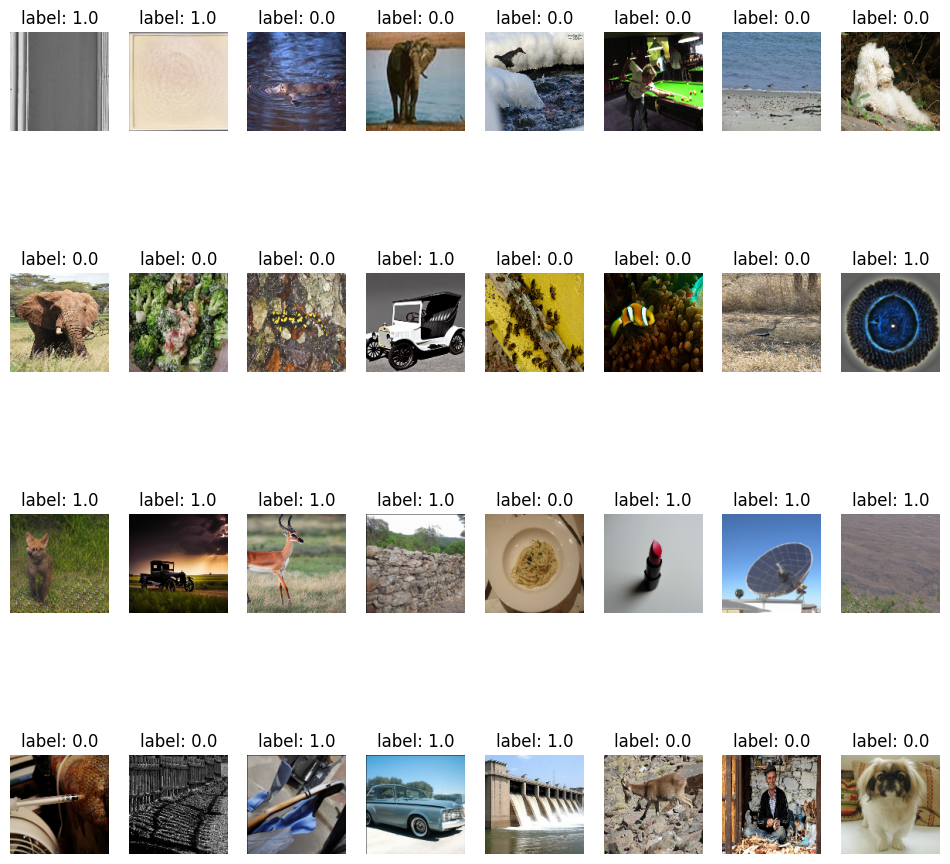

2026-02-17 20:34:13.171028: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
visualize_dataset(train_ds_final)

# 3. Baseline CNN model

In [ ]:
model_basic_cnn = Sequential(
    [
        #input layer
        layers.Input(shape=(128, 128, 3)),
        # rescale
        layers.Rescaling(1./255),
        # convolutional layer
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")

    ]
)

In [ ]:
model_basic_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model_basic_cnn.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
%%time
history_basic_cnn = model_basic_cnn.fit(
        train_ds_final,
        epochs=8,
        validation_data=val_ds_final
)

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [ ]:
plot_history(history_basic_cnn)

NameError: name 'history_basic_cnn' is not defined

In [ ]:
# Compare the performance of 2 models
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')


    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

In [ ]:
model_basic_cnn.evaluate(test_ds_final)

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8520 - loss: 0.3507


[0.3507034480571747, 0.852011501789093]

In [ ]:
model_basic_cnn.save("../models/basic_cnn.keras")

In [ ]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [ ]:
import requests
from io import BytesIO

def get_image(url):
    img_size= (128,128)
    response = requests.get(url=url)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def image_predict(url,model):
    img = get_image(url)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 128, 128, 3))
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    result = round(prediction[0][0],2)
    print(result)
    plt.imshow(img)
    plt.axis('off')
    if result<0.5:
        print(f"There are {result*100}% that the picrure is real picture, which is lower than 50%")
        print("Therefore, the picture is not AI generated")
    if result>=0.5:
        print(f"There are {result*100}% that the picrure is AI picture, which is higher than 50%")
        print("Therefore, the picture is AI generated")

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
0.93
There are 93.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


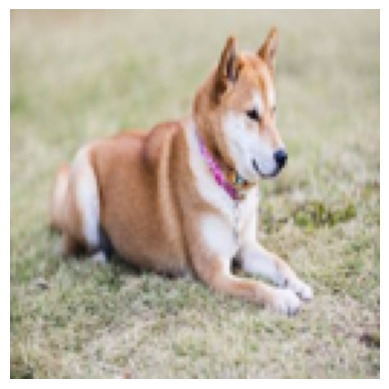

In [ ]:
image_predict(dog2,model_basic_cnn)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.93
There are 93.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


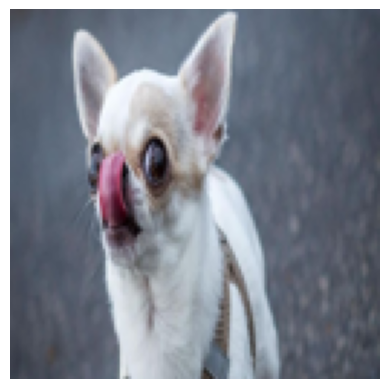

In [ ]:
image_predict(dog,model_basic_cnn)

# 4. Data augmentation for basic CNN

In [ ]:
data_augmentation = Sequential(
    [
    layers.RandomFlip(mode="horizontal", seed=42),
    layers.RandomRotation(0.03),
    # keep zoom/contrast conservative to avoid introducing unrealistic samples
    ]
)

In [ ]:
model_augmentation = Sequential(
    [
        #input layer
        layers.Input(shape=(128, 128, 3)),
        # rescale
        layers.Rescaling(1./255),
        # augmentation
        data_augmentation,
        # convolutional layer
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")

    ]
)

In [ ]:
model_augmentation.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = optimizers.Adam(learning_rate = 1e-4)
model_augmentation.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
MODEL = "../models/CNN_augmentaiton.keras"
modelCheckpoint = callbacks.ModelCheckpoint(filepath=MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

In [ ]:
%%time
history_model_aug = model_augmentation.fit(
        train_ds_final,
        epochs=10,
        validation_data=val_ds_final,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
        )

In [ ]:
history_model_aug.history

{'accuracy': [0.5388049483299255,
  0.5724490284919739,
  0.6034144163131714,
  0.660809338092804,
  0.7017393708229065,
  0.7210614681243896,
  0.7387049794197083,
  0.7480624318122864,
  0.7550626993179321,
  0.7598842978477478],
 'loss': [0.6867110729217529,
  0.6718056797981262,
  0.6531426310539246,
  0.6139058470726013,
  0.5790715217590332,
  0.5569323301315308,
  0.537935733795166,
  0.5257382392883301,
  0.5127337574958801,
  0.5034456849098206],
 'val_accuracy': [0.5490056872367859,
  0.5819128751754761,
  0.59375,
  0.6768465638160706,
  0.6877367496490479,
  0.640625,
  0.6946022510528564,
  0.6382575631141663,
  0.6666666865348816,
  0.6548295617103577],
 'val_loss': [0.6801311373710632,
  0.665425181388855,
  0.6610878705978394,
  0.625209391117096,
  0.6302339434623718,
  0.6807017922401428,
  0.5859047174453735,
  0.7077913284301758,
  0.6349380016326904,
  0.6605376601219177],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
 

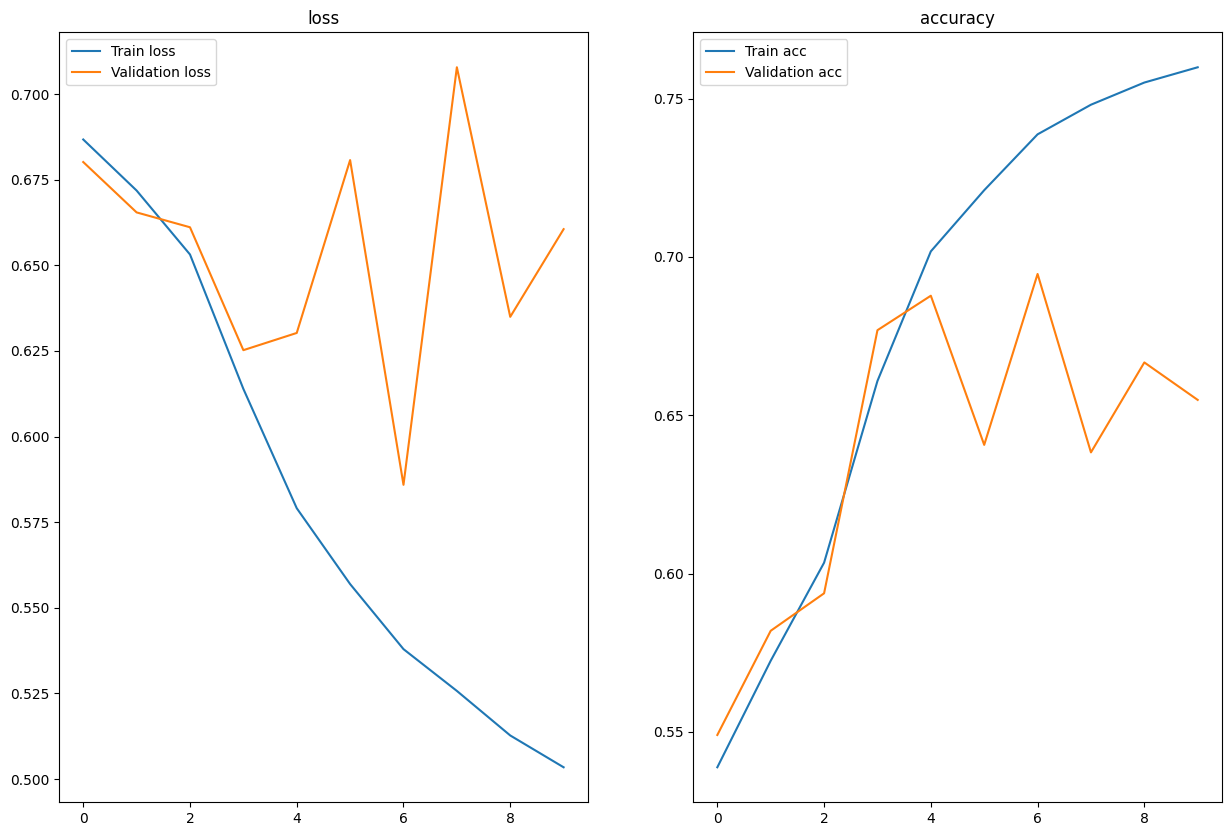

In [ ]:
plot_history(history_model_aug)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.63
There are 63.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


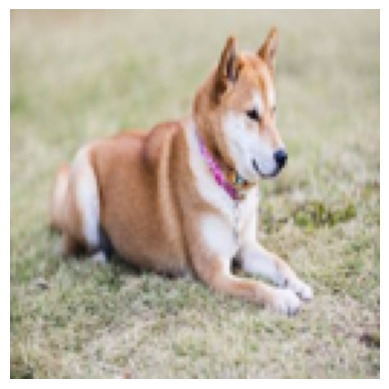

In [ ]:
image_predict(dog2,model_augmentation)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.62
There are 62.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


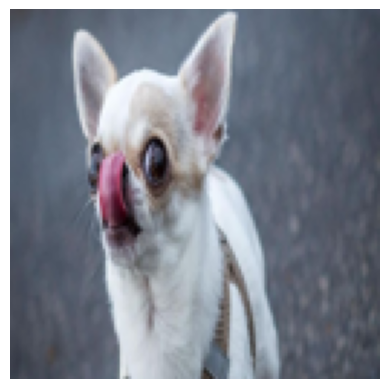

In [ ]:
image_predict(dog,model_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..247.43628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.328377..231.3068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.4052277..234.94765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.18098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.211723..244.63625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35085526..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..247.43628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.328377..231.3068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.4052277..234.94765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.18098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.211723..244.63625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35085526..255.0].


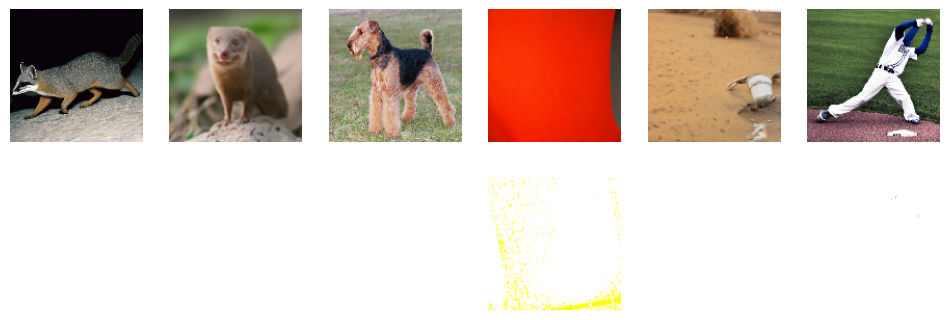

In [ ]:
# visualize data augmentation
for imgs, _ in train_ds_final.take(1):
    imgs = imgs[:6]
    aug = data_augmentation(imgs)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2, 6, figsize=(12,4))
    for i in range(6):
        ax[0,i].imshow(imgs[i].numpy().astype("uint8"))
        ax[0,i].axis("off")
        ax[1,i].imshow(aug[i].numpy())
        ax[1,i].axis("off")
    plt.show()
    break

# 5. Transfer Learning of EfficientNetB0

In [ ]:
# split datasets to train/val/test
IMG_SIZE= (300,300)
BATCH = 16
train_ds_b0,val_ds_b0, test_ds_b0 = split_merged_dataset(merged_path,0.3,BATCH,IMG_SIZE)

We are split datasets to train, val and test
----------------------------------------
Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Total batches: 2188
Train batches: 1750
Validation batches: 307
Test batches: 131
Split Done! and datasets are ready to feed the model
We are prefetch datasets
Done !


In [ ]:
def visualize_dataset(dataset,batch_number,augmentation=False):
    for imgs,labels in dataset.take(batch_number):
        batch_display = imgs.shape[0]
        if augmentation == True:
            imgs = data_augmentation_effb0(imgs)

        imgs = imgs.numpy().astype('float32')/255.0
        plt.figure(figsize=(12, 12))
        for i in range(batch_display):
            plt.subplot(8,4,i+1)
            plt.imshow(imgs[i])
            if labels[i].numpy()[0] == 0:
                plt.title("nature")
            else:
                plt.title("AI")
            plt.axis("off")
        plt.show()

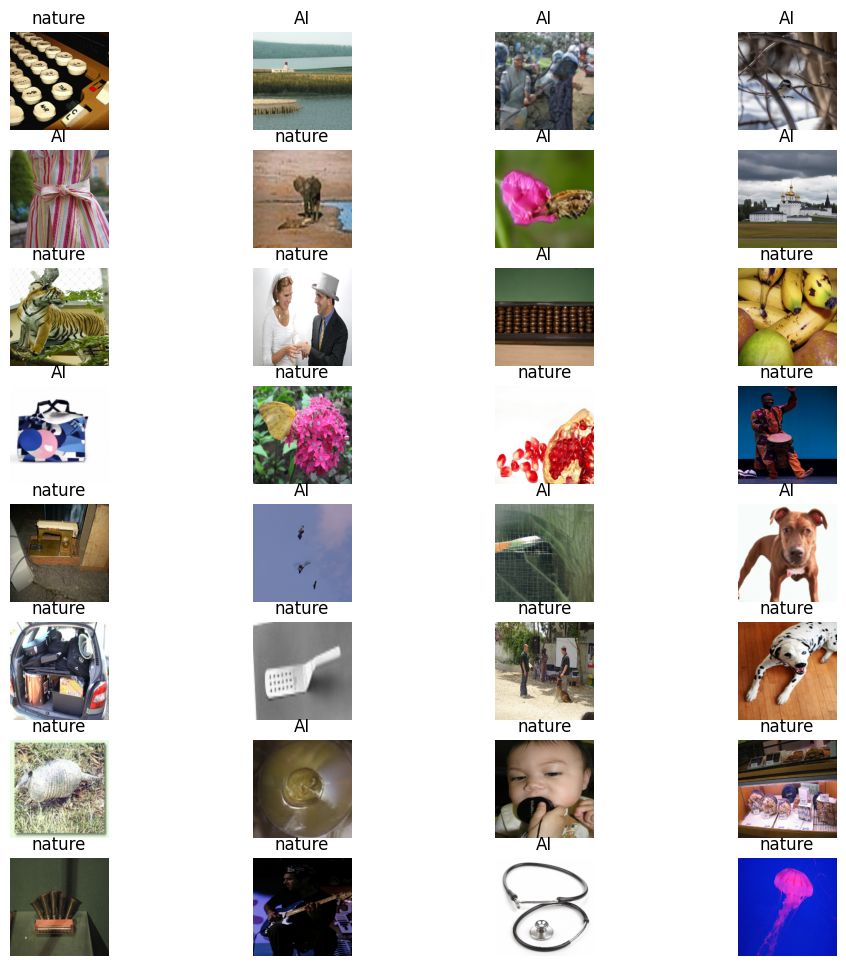

In [ ]:
visualize_dataset(train_ds_b0,1,augmentation=False)

In [ ]:
# 检查 dtype 和范围
for x,y in train_ds_final.take(3):
    print('dtype', x.dtype, 'shape', x.shape,
          'min', tf.reduce_min(x).numpy(), 'max', tf.reduce_max(x).numpy())
    break


2026-02-17 21:06:46.254127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:156: Filling up shuffle buffer (this may take a while): 424 of 1000
2026-02-17 21:06:56.258148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:156: Filling up shuffle buffer (this may take a while): 788 of 1000
2026-02-17 21:07:01.040746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


dtype <dtype: 'float32'> shape (32, 128, 128, 3) min 0.0 max 255.0


In [ ]:
# check distiribution
from collections import Counter
cnt = Counter()
for img,lbl in train_ds_b0.unbatch():
    cnt[int(lbl.numpy())]+=1
print('train class counts:', cnt)

In [ ]:
LOG_DIR = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/logs/effnetb0"
CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/best_model_b0.keras"

In [ ]:
# 2) data augmentation
data_augmentation_effb0 = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),           # ← 从0.04改为0.2（±11.5度）
    layers.RandomZoom(0.2),               # ← 从0.1改为0.2
    layers.RandomContrast(0.2),           # ← 从0.1改为0.2
    layers.RandomBrightness(0.2),         # ← 新增
    layers.RandomTranslation(0.1, 0.1),   # ← 新增
], name="augmentation")

In [ ]:
visualize_dataset(train_ds_b0,1,augmentation=True)

In [ ]:
#phase0:
# 2) data augmentation
data_augmentation_effb0 = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="augmentation")

# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH, monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=False
    ),
    callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]

# 5) buidl EfficientNetB0
base_model = EfficientNetB0 (
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='max'
)
# 6) Head freeze
base_model.trainable =False

# 7)Transfer Learning
model_EffB0 = Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb0,
    layers.Lambda(lambda x: preprocess_input(x)),
    base_model,
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Model compile
model_EffB0.compile(optimizer=optimizers.Adam(1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy','auc'])
# Model fit
history_b0 = model_EffB0.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=10, callbacks=callbacks_list)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 75s 72ms/step - accuracy: 0.5343 - auc: 0.5440 - loss: 0.9765 - val_accuracy: 0.6181 - val_auc: 0.6721 - val_loss: 0.7074 - learning_rate: 1.0000e-04
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - accuracy: 0.5949 - auc: 0.6334 - loss: 0.7370 - val_accuracy: 0.6344 - val_auc: 0.7184 - val_loss: 0.6845 - learning_rate: 1.0000e-04
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.6391 - auc: 0.6893 - loss: 0.6984 - val_accuracy: 0.6719 - val_auc: 0.7533 - val_loss: 0.6553 - learning_rate: 1.0000e-04
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.6510 - auc: 0.7068 - loss: 0.6841 - val_accuracy: 0.6728 - val_auc: 0.7718 - val_loss: 0.6571 - learning_rate: 1.0000e-04
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - accuracy: 0.6646 - auc: 0.7296 - loss: 0.6642 - val_accuracy: 0.6766 - val_auc: 0.7834 - val_loss: 0.6511 - learning_rate: 1.0000e-04
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/s

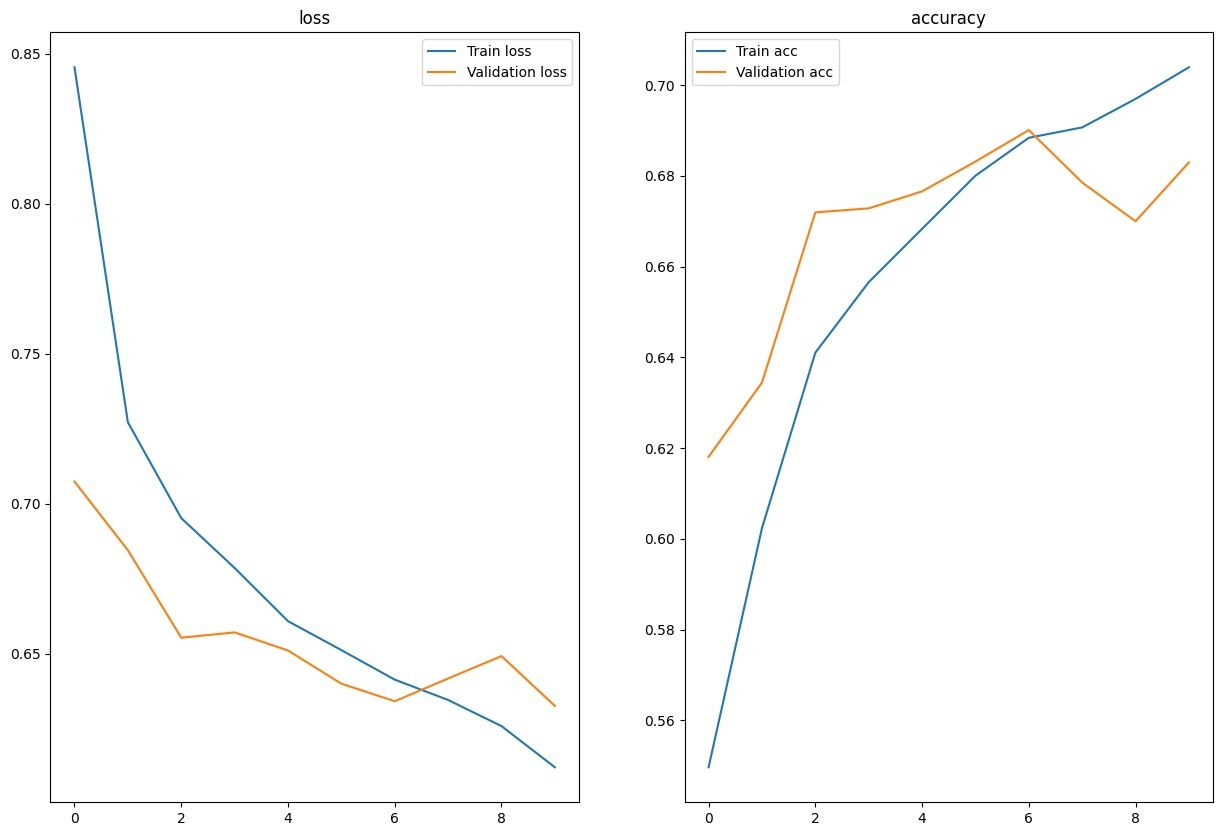

In [ ]:
plot_history(history_b0)

In [ ]:
  # phase 1 :
# 2) data augmentation
data_augmentation_effb0 = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),           # ← 从0.04改为0.2（±11.5度）
    layers.RandomZoom(0.2),               # ← 从0.1改为0.2
    layers.RandomContrast(0.2),           # ← 从0.1改为0.2
    layers.RandomBrightness(0.2),         # ← 新增
    layers.RandomTranslation(0.1, 0.1),   # ← 新增
], name="augmentation")

# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH, monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=False
    ),
    callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]

# 5) buidl EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='max'
)
# 6) Head freeze
base_model.trainable =False

# 7)Transfer Learning
model_EffB0 = Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb0,
    layers.Lambda(lambda x: preprocess_input(x)),
    base_model,
    layers.Dense(600, activation='relu', kernel_regularizer='l2'),  # ← 加L2
    layers.BatchNormalization(),  # ← 新增
    layers.Dropout(0.4),  # ← 从0.3改为0.4
    layers.Dense(300, activation='relu', kernel_regularizer='l2'),  # ← 加L2
    layers.BatchNormalization(),  # ← 新增
    layers.Dropout(0.3),  # ← 从0.3改为0.4
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Unfreeze last 20 layers
base_model.trainable = True

for layer in base_model.layers[:-15]:
    layer.trainable = False

# Model compile
model_EffB0.compile(optimizer=optimizers.Adam(1e-5),
                    loss='binary_crossentropy',
                    metrics=['accuracy','auc'])
# Model fit
history_b0 = model_EffB0.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=8, callbacks=callbacks_list)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 559s 534ms/step - accuracy: 0.5284 - auc: 0.5383 - loss: 12.9709 - val_accuracy: 0.6024 - val_auc: 0.6503 - val_loss: 12.3795 - learning_rate: 1.0000e-05
Epoch 2/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.5796 - auc: 0.6083 - loss: 12.3590 - val_accuracy: 0.6369 - val_auc: 0.7001 - val_loss: 11.8448 - learning_rate: 1.0000e-05
Epoch 3/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.5996 - auc: 0.6375 - loss: 11.8411 - val_accuracy: 0.6612 - val_auc: 0.7340 - val_loss: 11.3543 - learning_rate: 1.0000e-05
Epoch 4/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 64s 74ms/step - accuracy: 0.6243 - auc: 0.6714 - loss: 11.3348 - val_accuracy: 0.6707 - val_auc: 0.7546 - val_loss: 10.8969 - learning_rate: 1.0000e-05
Epoch 5/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.6317 - auc: 0.6829 - loss: 10.8764 - val_accuracy: 0.6744 - val_auc: 0.7700 - val_loss: 10.4648 - learning_rate: 1.0

In [ ]:
model_EffB0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 600)            │       768,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 600)            │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,716,184 (33.25 MB)

 Trainable params: 1,856,905 (7.08 MB)

 Non-trainable params: 3,145,467 (12.00 MB)

 Optimizer params: 3,713,812 (14.17 MB)

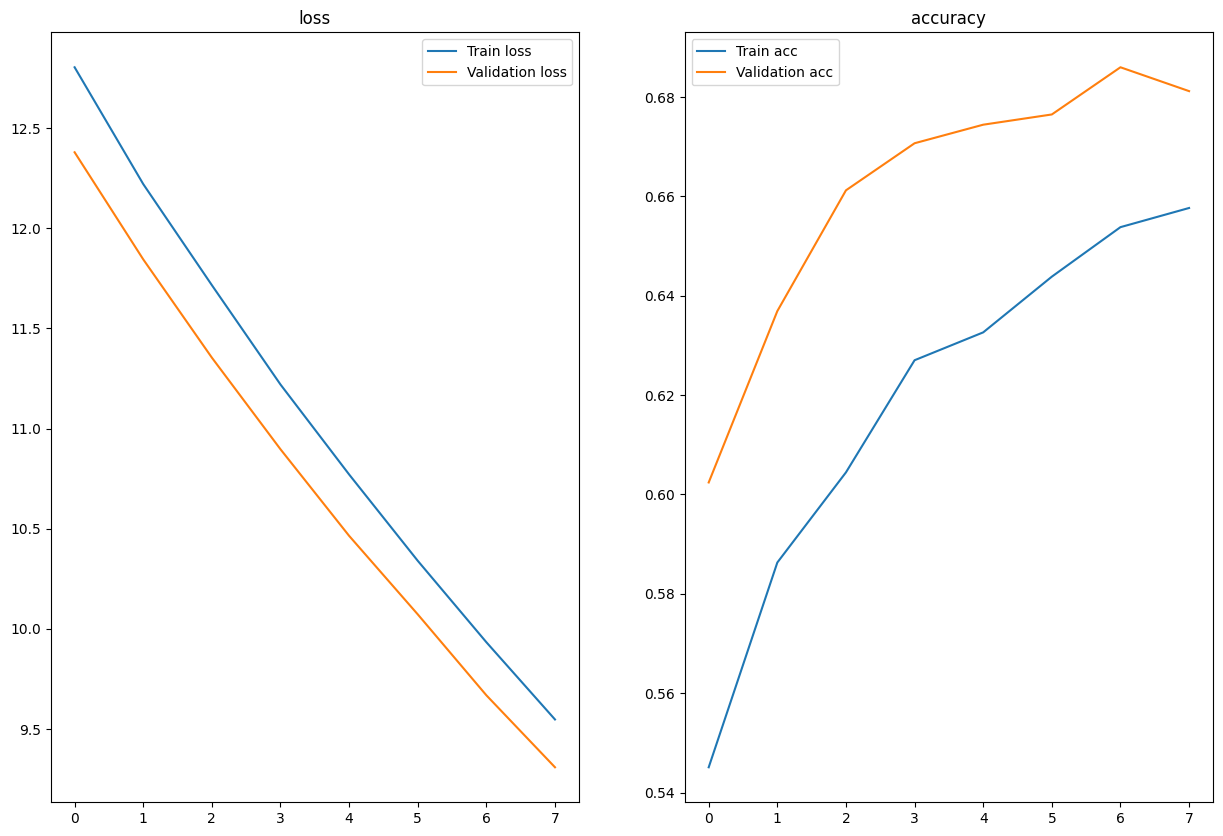

In [ ]:
plot_history(history_b0)

In [ ]:
# phase 2  :
# 2) data augmentation
data_augmentation_effb0 = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),           # ← 从0.04改为0.2（±11.5度）
    layers.RandomZoom(0.2),               # ← 从0.1改为0.2
    layers.RandomContrast(0.2),           # ← 从0.1改为0.2
    layers.RandomBrightness(0.2),         # ← 新增
    layers.RandomTranslation(0.1, 0.1),   # ← 新增
], name="augmentation")

# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH, monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=False
    ),
    callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-8
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]

# 5) buidl EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='max'
)
# 6) Head freeze
base_model.trainable =False

# 7)Transfer Learning
model_EffB0 = Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb0,
    layers.Lambda(lambda x: preprocess_input(x)),
    base_model,
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),  # ← 新增
    layers.Dropout(0.4),  # ← 从0.3改为0.4
    layers.Dense(128, activation='relu', kernel_regularizer= regularizers.l2(1e-4)),
    layers.BatchNormalization(),  # ← 新增
    layers.Dropout(0.3),  # ← 从0.3改为0.4
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Unfreeze last 20 layers
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Model compile
model_EffB0.compile(optimizer=optimizers.Adam(5e-6),
                    loss='binary_crossentropy',
                    metrics=['accuracy','auc','recall','precision'])
# Model fit
history_b0 = model_EffB0.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=20, callbacks=callbacks_list)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 89s 84ms/step - accuracy: 0.5115 - auc: 0.5156 - loss: 1.0117 - precision: 0.5098 - recall: 0.5182 - val_accuracy: 0.5585 - val_auc: 0.5693 - val_loss: 0.8717 - val_precision: 0.5542 - val_recall: 0.6009 - learning_rate: 5.0000e-06
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5367 - auc: 0.5490 - loss: 0.9532 - precision: 0.5330 - recall: 0.5458 - val_accuracy: 0.5734 - val_auc: 0.6063 - val_loss: 0.8275 - val_precision: 0.5662 - val_recall: 0.6069 - learning_rate: 5.0000e-06
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5547 - auc: 0.5809 - loss: 0.9129 - precision: 0.5547 - recall: 0.5645 - val_accuracy: 0.5944 - val_auc: 0.6275 - val_loss: 0.8061 - val_precision: 0.5892 - val_recall: 0.6205 - learning_rate: 5.0000e-06
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5736 - auc: 0.6044 - loss: 0.8787 - precision: 0.5686 - recall: 0.5819 - val_accuracy: 0.6097 - val_auc: 0.6547 - va

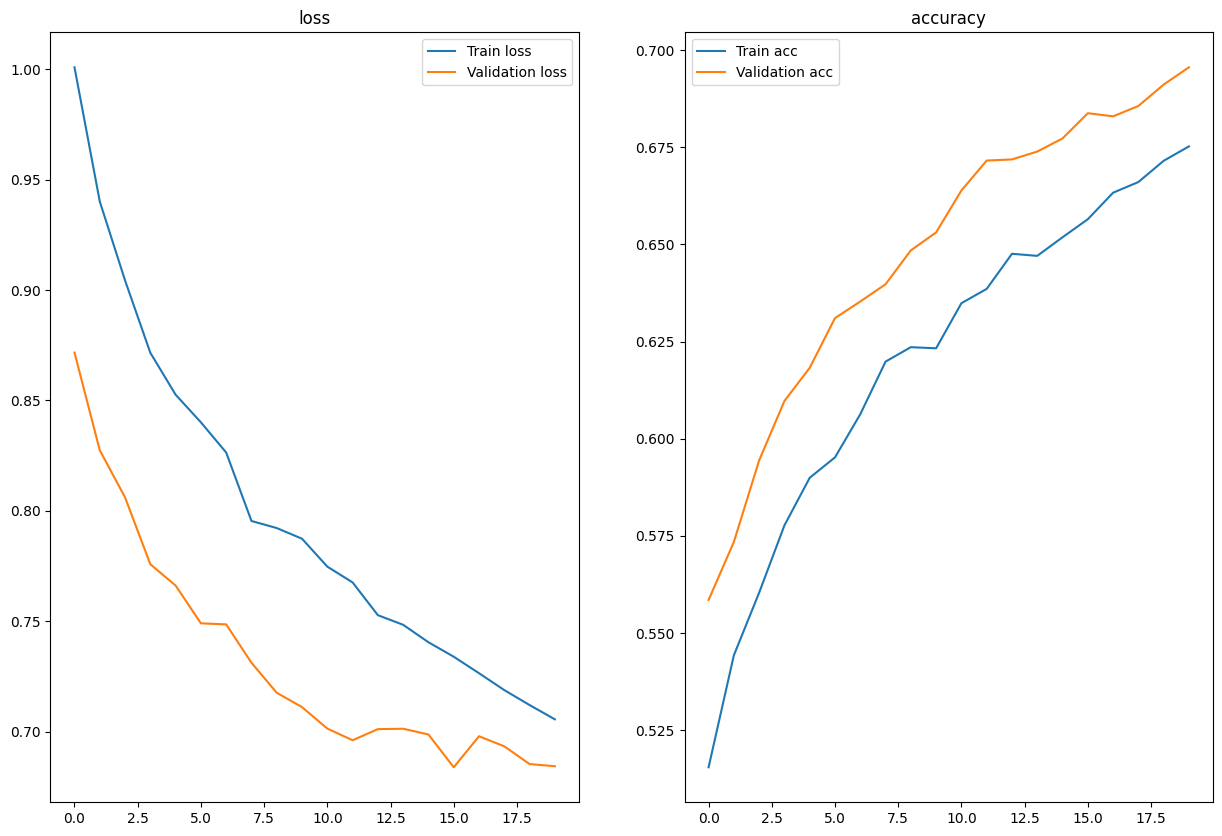

In [ ]:
plot_history(history_b0)

In [ ]:
# ============ Phase 3: 提高Accuracy ============

print("=" * 70)
print("Phase 3: 提高Accuracy")
print("=" * 70)

# 步骤1: 重新构建模型（增加容量，减少正则化）
model_EffB0 = Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb0,
    layers.Lambda(lambda x: preprocess_input(x)),
    base_model,
    layers.Dense(
        384,  # 256 → 384
        activation='relu',
        kernel_regularizer=regularizers.l2(5e-5),  # 1e-4 → 5e-5
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # 0.4 → 0.3
    layers.Dense(
        192,  # 128 → 192
        activation='relu',
        kernel_regularizer=regularizers.l2(5e-5),  # 1e-4 → 5e-5
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # 0.3 → 0.2
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# 步骤2: 解冻更多层
base_model.trainable = True
unfrozen_layers = 50  # 30 → 50

for layer in base_model.layers[:-unfrozen_layers]:
    layer.trainable = False

print(f"✓ 解冻了EfficientNetB0的最后{unfrozen_layers}层")

# 步骤3: 编译
model_EffB0.compile(
    optimizer=optimizers.Adam(1.5e-6),  # 2e-6 → 1.5e-6
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)

# 步骤4: 改进的回调
callbacks_phase3 = [
    callbacks.ModelCheckpoint(
        CKPT_PATH,
        monitor="val_accuracy",  # ← 改为监控Accuracy
        mode="max",
        save_best_only=True,
        save_weights_only=False
    ),
    callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-9
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]

# 步骤5: 训练
print(f"\n开始训练Phase 3...")
print(f"优化目标: 提高Accuracy")
print(f"=" * 70)

history_phase3 = model_EffB0.fit(
    train_ds_b0,
    validation_data=val_ds_b0,
    epochs=40,  # 20 → 40（更多epoch）
    callbacks=callbacks_phase3,
    initial_epoch=20
)

# 步骤6: 评估
print("\n" + "=" * 70)
print("Phase 3 完成 - 最终评估")
print("=" * 70)

from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_probs = model_EffB0.predict(val_ds_b0)
y_true = np.concatenate([y for x, y in val_ds_b0], axis=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"✓ Validation Accuracy: {accuracy:.4f}")
print(f"✓ True Positives: {tp}")
print(f"✓ True Negatives: {tn}")
print(f"✓ False Positives: {fp}")
print(f"✓ False Negatives: {fn}")

Phase 3: 提高Accuracy
✓ 解冻了EfficientNetB0的最后50层

开始训练Phase 3...
优化目标: 提高Accuracy
Epoch 21/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 86s 81ms/step - accuracy: 0.5410 - auc: 0.5534 - loss: 0.8957 - val_accuracy: 0.5597 - val_auc: 0.5827 - val_loss: 0.8698 - learning_rate: 1.5000e-06
Epoch 22/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.5526 - auc: 0.5769 - loss: 0.8734 - val_accuracy: 0.5724 - val_auc: 0.6052 - val_loss: 0.8485 - learning_rate: 1.5000e-06
Epoch 23/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 76ms/step - accuracy: 0.5746 - auc: 0.6062 - loss: 0.8424 - val_accuracy: 0.5960 - val_auc: 0.6339 - val_loss: 0.8169 - learning_rate: 1.5000e-06
Epoch 24/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.5906 - auc: 0.6267 - loss: 0.8148 - val_accuracy: 0.6087 - val_auc: 0.6511 - val_loss: 0.7957 - learning_rate: 1.5000e-06
Epoch 25/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.6015 - auc: 0.6417 - loss: 0.8043 - val_accuracy: 0.6214 - val_auc: 0.6705 - val_loss: 0

# 6. Transfer learning with EfficientB3



In [ ]:
# split datasets to train/val/test
IMG_SIZE= (240,240)
BATCH = 64
train_ds_b0,val_ds_b0, test_ds_b0 = split_merged_dataset(merged_path,0.3,BATCH,IMG_SIZE)

We are split datasets to train, val and test
----------------------------------------
Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Total batches: 548
Train batches: 438
Validation batches: 77
Test batches: 33
Split Done! and datasets are ready to feed the model
We are prefetch datasets
Done !


In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

##6.1 Transfer learning with EfficientB3 train #1



In [ ]:
LOG_DIR = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/logs/efficientNetB3_freeze_1"
CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_freeze_30_1.keras"
CKPT_PATH2 = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_freeze_30_1.weights.h5"

In [ ]:
#phase0:
# 2) data augmentation
data_augmentation_effb3 = Sequential([
    layers.RandomFlip("horizontal"),  # 保留
    layers.RandomRotation(0.1),       # 减小旋转角度（0.2 -> 0.1）
    # layers.RandomZoom(0.2),         # 考虑移除，可能破坏边缘伪影
    # layers.RandomContrast(0.2),     # 移除，AI图片在对比度上有特征
    # layers.RandomBrightness(0.2),   # 移除，亮度分布是判别特征
    # layers.RandomTranslation(0.1, 0.1),  # 移除，边缘特征重要
], name="augmentation")

# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=False
    ),
  callbacks.ModelCheckpoint(
        CKPT_PATH2,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=True
    ),
    callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True,verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-7,verbose=1
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]


# 5) buidl RestNet50
model_effb3 = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)
# 6) Head freeze
model_effb3.trainable =False

# 7)Transfer Learning
model_effb3= Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb3,
    layers.Lambda(lambda x: preprocess_input(x)),
    model_effb3,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.35),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Model compile
model_effb3.compile(optimizer=optimizers.Adam(1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy','auc'])
# Model fit
history_b3 = model_effb3.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=30, callbacks=callbacks_list)


Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1217s 786ms/step - accuracy: 0.5446 - auc: 0.5653 - loss: 0.9187 - val_accuracy: 0.6909 - val_auc: 0.7604 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 262ms/step - accuracy: 0.6406 - auc: 0.6941 - loss: 0.7561 - val_accuracy: 0.7128 - val_auc: 0.7864 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 115s 262ms/step - accuracy: 0.6849 - auc: 0.7532 - loss: 0.6934 - val_accuracy: 0.7265 - val_auc: 0.8039 - val_loss: 0.6521 - learning_rate: 1.0000e-04
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 261ms/step - accuracy: 0.6980 - auc: 0.7688 - loss: 0.6765 - val_accuracy: 0.7285 - val_auc: 0.8092 - val_loss: 0.6454 - learning_rate: 1.0000e-04
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 261ms/step - accuracy: 0.7181 - auc: 0.7921 - loss: 0.6515 - val_accuracy: 0.7287 - val_auc: 0.8159 - val_loss: 0.6415 - learning_rate: 1.0000e-04
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━

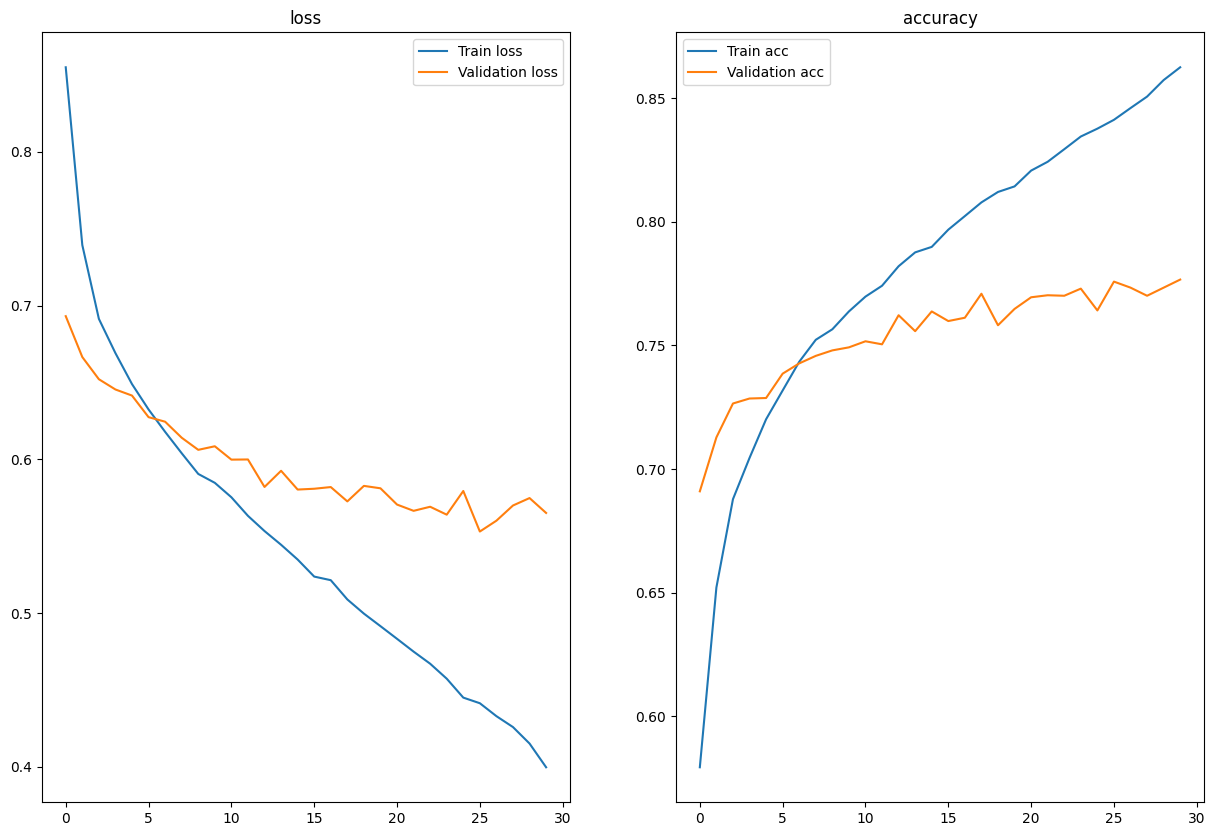

In [ ]:
plot_history(history_b3)

In [ ]:
history_b3.history['val_accuracy'][-1]

0.7765957713127136

## 6.2 Transfer learning with EfficientB3 train #2

In [ ]:
LOG_DIR = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/logs/efficientNetB3"
CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_hea_val_auc_freeze_30.keras"
CKPT_PATH2 = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_freeze_30.weights.h5"

In [ ]:
LOG_DIR = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/logs/efficientNetB3"
CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_hea_val_auc_freeze_30_2.keras"
CKPT_PATH2 = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_freeze_30_2.weights.h5"

In [ ]:
# split datasets to train/val/test
IMG_SIZE= (240,240)
BATCH = 64
train_ds_b0,val_ds_b0, test_ds_b0 = split_merged_dataset(merged_path,0.3,BATCH,IMG_SIZE)

We are split datasets to train, val and test
----------------------------------------
Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Total batches: 548
Train batches: 438
Validation batches: 77
Test batches: 33
Split Done! and datasets are ready to feed the model
We are prefetch datasets
Done !


In [ ]:
#phase0:
# 2) data augmentation
data_augmentation_effb3 = Sequential([
    layers.RandomFlip("horizontal"),  # 保留
    layers.RandomRotation(0.12),       # 减小旋转角度（0.2 -> 0.1）
    layers.RandomZoom(0.1),         # 考虑移除，可能破坏边缘伪影
    # layers.RandomContrast(0.2),     # 移除，AI图片在对比度上有特征
    # layers.RandomBrightness(0.2),   # 移除，亮度分布是判别特征
    # layers.RandomTranslation(0.1, 0.1),  # 移除，边缘特征重要
], name="augmentation")

# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
  callbacks.ModelCheckpoint(
        CKPT_PATH2,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True,verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-7,verbose=1
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]


# 5) buidl RestNet50
base_model_effb3 = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)
# 6) Head freeze
base_model_effb3.trainable =False

# 7)Transfer Learning
model_effb3= Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb3,
    layers.Lambda(preprocess_input),
    base_model_effb3,
    layers.BatchNormalization(),
    # 新增=================
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.4),
    #==========================
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.45),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.45),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Model compile
model_effb3.compile(optimizer=optimizers.Adam(1.5e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy','auc'])

In [ ]:
# Model fit
history_b3 = model_effb3.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=30, callbacks=callbacks_list)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5367 - auc: 0.5462 - loss: 1.0476
Epoch 1: val_auc improved from -inf to 0.74763, saving model to /content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_hea_val_auc_freeze_30_2.keras

Epoch 1: val_auc improved from -inf to 0.74763, saving model to /content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_freeze_30_2.weights.h5
438/438 ━━━━━━━━━━━━━━━━━━━━ 305s 277ms/step - accuracy: 0.5368 - auc: 0.5463 - loss: 1.0475 - val_accuracy: 0.6764 - val_auc: 0.7476 - val_loss: 0.8867 - learning_rate: 1.5000e-04
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6377 - auc: 0.6916 - loss: 0.8888
Epoch 2: val_auc improved from 0.74763 to 0.78443, saving model to /content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_hea_val_auc_freeze_30_2.keras

Epoch 2: val_auc improved from 0.74763 to 0.78443, saving model to /content/drive/MyDriv

In [ ]:
baseline_acc = history_b3.history['val_accuracy'][-1]
baseline_acc

0.7632978558540344

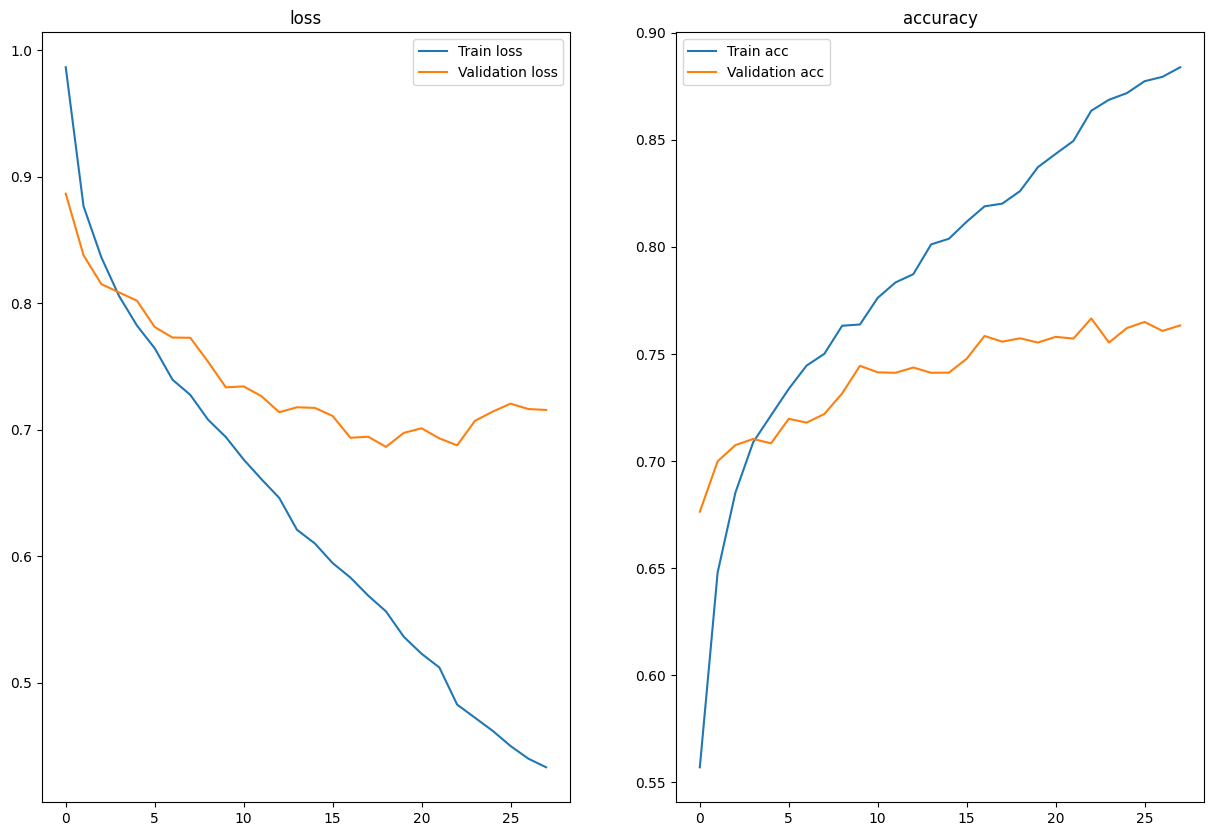

In [ ]:

plot_history(history_b3)

In [ ]:
# 1. 模型架构摘要
print("\n1️⃣ 模型架构:")
best_model.summary()
# 2. model config
print("\n2️⃣ model configuration:")
config = best_model.get_config()
print(f"   model type: {config['name']}")
print(f"   Layers : {len(config['layers'])}")
#3. structure:
print("\n3️⃣ layer structure:")
for i, layer in enumerate(best_model.layers):
    trainable_str = "✅ Trainable" if layer.trainable else "❌ Frozen"
    print(f"  [{i}] {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

    # 如果是EfficientNetB3 base model
    if 'efficientnetb3' in layer.name.lower():
        print(f"      └─ 包含 {len(layer.layers)} 个子层")
#4. Optimizer info:
print("\n5️⃣ optimizer:")
optimizer = best_model.optimizer
print(f"  type: {optimizer.__class__.__name__}")
print(f"  learning rate: {optimizer.learning_rate.numpy():.2e}")
if hasattr(optimizer, 'iterations'):
    print(f"  trainign steps: {optimizer.iterations.numpy():,}")
# 6. 编译信息
print("\n6️⃣ 编译信息:")
print(f"  损失函数: {best_model.loss}")
print(f"  评估指标: {[m.name for m in best_model.metrics]}")
# 8. 检查base model是否冻结
print("\n8️⃣ Base Model状态:")
base_model = best_model.layers[2]  # EfficientNetB3
print(f"  Base model name : {base_model.name}")
print(f"  Base model trainanle: {base_model.trainable}")
frozen_layers = sum([1 for l in base_model.layers if not l.trainable])
print(f"  冻结层数: {frozen_layers}/{len(base_model.layers)}")



1️⃣ 模型架构:


NameError: name 'best_model' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 加载权重（✅ 不涉及Lambda反序列化）
model_effb3.load_weights(CKPT_PATH2)
print("Loaded weights:", CKPT_PATH2)

# ====== 2) 收集验证集真实标签与预测概率 ======
y_true = []
y_prob = []

for image,label in val_ds_b0:
    pred= model_effb3.predict(image, verbose=0).reshape(-1)
    y_true.append(label.numpy().reshape(-1))
    y_prob.append(pred)

y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob).astype(float)
print(y_prob)
print(f"Val samples: {len(y_true)}")
print(f"Prob range: [{y_prob.min():.4f}, {y_prob.max():.4f}]")
print(f"ROC AUC (threshold-free): {roc_auc_score(y_true, y_prob):.4f}")

Loaded weights: /content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_freeze_30.weights.h5
[1.77068245e-02 3.20361704e-01 3.63700151e-01 ... 1.25195684e-05
 3.44230473e-01 2.66974896e-01]
Val samples: 4216
Prob range: [0.0000, 1.0000]
ROC AUC (threshold-free): 0.8512


In [ ]:
threshold = np.linspace(0.0,1.0,2001)
tp = np.array([((y_prob >= t) & (y_true == 1)).sum() for t in threshold])
fp = np.array([((y_prob>=t)&(y_true==0)).sum() for t in threshold])
fn =  np.array([((y_prob<t)&(y_true==1)).sum() for t in threshold])
precision = tp / (tp + fp + 1e-12)
recall    = tp / (tp + fn + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.argmax(f1))
best_threshold = float(threshold[best_idx])
best_f1 = float(f1[best_idx])
best_recall = float(recall[best_idx])
best_precision = float(precision[best_idx])
print(f"Best threshold: {best_threshold:.4f}")
print(f"Best f1: {best_f1:.4f}")
print(f"Best recall to keep f1 best: {best_recall  :.4f}")
print(f"Best precesion to keep f1 best : {best_precision:.4f}")

Best threshold: 0.1885
Best f1: 0.7722
Best recall to keep f1 best: 0.8444
Best precesion to keep f1 best : 0.7115


In [ ]:
thresholds = np.linspace(0.0, 1.0, 2001)
accs = np.array([accuracy_score(y_true, (y_prob >= t).astype(int)) for t in thresholds])

best_idx = int(np.argmax(accs))
best_t = float(thresholds[best_idx])
best_acc = float(accs[best_idx])

acc_05 = float(accuracy_score(y_true, (y_prob >= 0.5).astype(int)))

print("\n=== Threshold optimization on VAL ===")
print(f"Acc@0.5      : {acc_05:.4f}")
print(f"Best threshold: {best_t:.4f}")
print(f"Best Acc      : {best_acc:.4f}  (improve {best_acc - acc_05:+.4f})")


=== Threshold optimization on VAL ===
Acc@0.5      : 0.7626
Best threshold: 0.3905
Best Acc      : 0.7716  (improve +0.0090)


In [ ]:
y_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_best)
print("\nConfusion Matrix (VAL, best_t):")
print(cm)

print("\nClassification Report (VAL, best_t):")
print(classification_report(y_true, y_pred_best, digits=4))


Confusion Matrix (VAL, best_t):
[[1421  713]
 [ 324 1758]]

Classification Report (VAL, best_t):
              precision    recall  f1-score   support

           0     0.8143    0.6659    0.7327      2134
           1     0.7115    0.8444    0.7722      2082

    accuracy                         0.7540      4216
   macro avg     0.7629    0.7551    0.7525      4216
weighted avg     0.7635    0.7540    0.7522      4216



## 6.3 Transfer learning with EfficientB3 train #3

In [ ]:
LOG_DIR = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/logs/efficientNetB3"
CKPT_PATH_UNFREEZE_MODEL= "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_unfreeze_30.keras"
CKPT_PATH_FREEZE_WEIGHT = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_freeze_30.weights.h5"
CKPT_PATH_UNFREEZE_WEIGHT = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/checkpoints/efficientNetB3_head_val_auc_unfreeze_30.weights.h5"

In [ ]:
data_augmentation_effb3 = Sequential([
    layers.RandomFlip("horizontal"),  # 保留
    layers.RandomRotation(0.12),       # 减小旋转角度（0.2 -> 0.1）
    layers.RandomZoom(0.1),         # 考虑移除，可能破坏边缘伪影
    # layers.RandomContrast(0.2),     # 移除，AI图片在对比度上有特征
    # layers.RandomBrightness(0.2),   # 移除，亮度分布是判别特征
    # layers.RandomTranslation(0.1, 0.1),  # 移除，边缘特征重要
], name="augmentation")

# 5) buidl RestNet50
base_model_effb3 = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

# 6) Head freeze
base_model_effb3.trainable =False

# 7)Transfer Learning
model_effb3= Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation_effb3,
    layers.Lambda(preprocess_input),
    base_model_effb3,
    layers.BatchNormalization(),
    # 新增=================
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(2e-4)),  # 256→512
    layers.Dropout(0.4),
    #==========================
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.45),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(2e-4)),
    layers.Dropout(0.45),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])


In [ ]:
model_effb3.load_weights(CKPT_PATH_FREEZE_WEIGHT)

base_model_effb3.trainable=True

for layer in base_model_effb3.layers[:-40]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

In [ ]:
# 3) Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        CKPT_PATH_UNFREEZE_MODEL,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
    ),
  callbacks.ModelCheckpoint(
        CKPT_PATH_UNFREEZE_WEIGHT,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    ),
    callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.TensorBoard(log_dir=LOG_DIR),
]

model_effb3.compile(
    optimizer=optimizers.Adam(learning_rate=3e-6),
    loss="binary_crossentropy",
    metrics=["accuracy", "auc"]
)


In [ ]:
# 1. 模型架构摘要
print("\n1️⃣ 模型架构:")
model_effb3.summary()
# 2. model config
print("\n2️⃣ model configuration:")
config = model_effb3.get_config()
print(f"   model type: {config['name']}")
print(f"   Layers : {len(config['layers'])}")
#3. structure:
print("\n3️⃣ layer structure:")
for i, layer in enumerate(model_effb3.layers):
    trainable_str = "✅ Trainable" if layer.trainable else "❌ Frozen"
    print(f"  [{i}] {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

    # 如果是EfficientNetB3 base model
    if 'efficientnetb3' in layer.name.lower():
        print(f"      └─ 包含 {len(layer.layers)} 个子层")
#4. Optimizer info:
print("\n5️⃣ optimizer:")
optimizer = model_effb3.optimizer
print(f"  type: {optimizer.__class__.__name__}")
print(f"  learning rate: {optimizer.learning_rate.numpy():.2e}")
if hasattr(optimizer, 'iterations'):
    print(f"  trainign steps: {optimizer.iterations.numpy():,}")
# 6. 编译信息
print("\n6️⃣ 编译信息:")
print(f"  损失函数: {model_effb3.loss}")
print(f"  评估指标: {[m.name for m in model_effb3.metrics]}")
# 8. 检查base model是否冻结
print("\n8️⃣ Base Model状态:")
base_model = model_effb3.layers[2]  # EfficientNetB3
print(f"  Base model name : {base_model.name}")
print(f"  Base model trainanle: {base_model.trainable}")
frozen_layers = sum([1 for l in base_model.layers if not l.trainable])
print(f"  冻结层数: {frozen_layers}/{len(base_model.layers)}")



1️⃣ 模型架构:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,740,976 (44.79 MB)

 Trainable params: 5,385,253 (20.54 MB)

 Non-trainable params: 6,355,723 (24.25 MB)


2️⃣ model configuration:
   model type: sequential_1
   Layers : 12

3️⃣ layer structure:
  [0] augmentation                   | Sequential           | ✅ Trainable
  [1] lambda_1                       | Lambda               | ✅ Trainable
  [2] efficientnetb3                 | Functional           | ✅ Trainable
      └─ 包含 386 个子层
  [3] batch_normalization_1          | BatchNormalization   | ✅ Trainable
  [4] dense_4                        | Dense                | ✅ Trainable
  [5] dropout_3                      | Dropout              | ✅ Trainable
  [6] dense_5                        | Dense                | ✅ Trainable
  [7] dropout_4                      | Dropout              | ✅ Trainable
  [8] dense_6                        | Dense                | ✅ Trainable
  [9] dropout_5                      | Dropout              | ✅ Trainable
  [10] dense_7                        | Dense                | ✅ Trainable

5️⃣ optimizer:
  type: Adam
  learning rate: 3.00e-06
  trainign steps: 0

In [ ]:
model_effb3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,740,976 (44.79 MB)

 Trainable params: 5,385,253 (20.54 MB)

 Non-trainable params: 6,355,723 (24.25 MB)

In [ ]:
# Model fit
history_b3 = model_effb3.fit(train_ds_b0, validation_data=val_ds_b0,
                epochs=20, callbacks=callbacks_list)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 452s 463ms/step - accuracy: 0.7914 - auc: 0.8756 - loss: 0.6142 - val_accuracy: 0.7085 - val_auc: 0.7933 - val_loss: 0.7639 - learning_rate: 3.0000e-06
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 402s 459ms/step - accuracy: 0.8096 - auc: 0.8924 - loss: 0.5764 - val_accuracy: 0.7165 - val_auc: 0.8014 - val_loss: 0.7602 - learning_rate: 3.0000e-06
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 400s 458ms/step - accuracy: 0.8109 - auc: 0.8926 - loss: 0.5757 - val_accuracy: 0.7206 - val_auc: 0.8066 - val_loss: 0.7491 - learning_rate: 3.0000e-06
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 400s 458ms/step - accuracy: 0.8159 - auc: 0.9005 - loss: 0.5587 - val_accuracy: 0.7276 - val_auc: 0.8175 - val_loss: 0.7405 - learning_rate: 3.0000e-06
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 400s 457ms/step - accuracy: 0.8222 - auc: 0.9028 - loss: 0.5554 - val_accuracy: 0.7293 - val_auc: 0.8224 - val_loss: 0.7335 - learning_rate: 3.0000e-06
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 

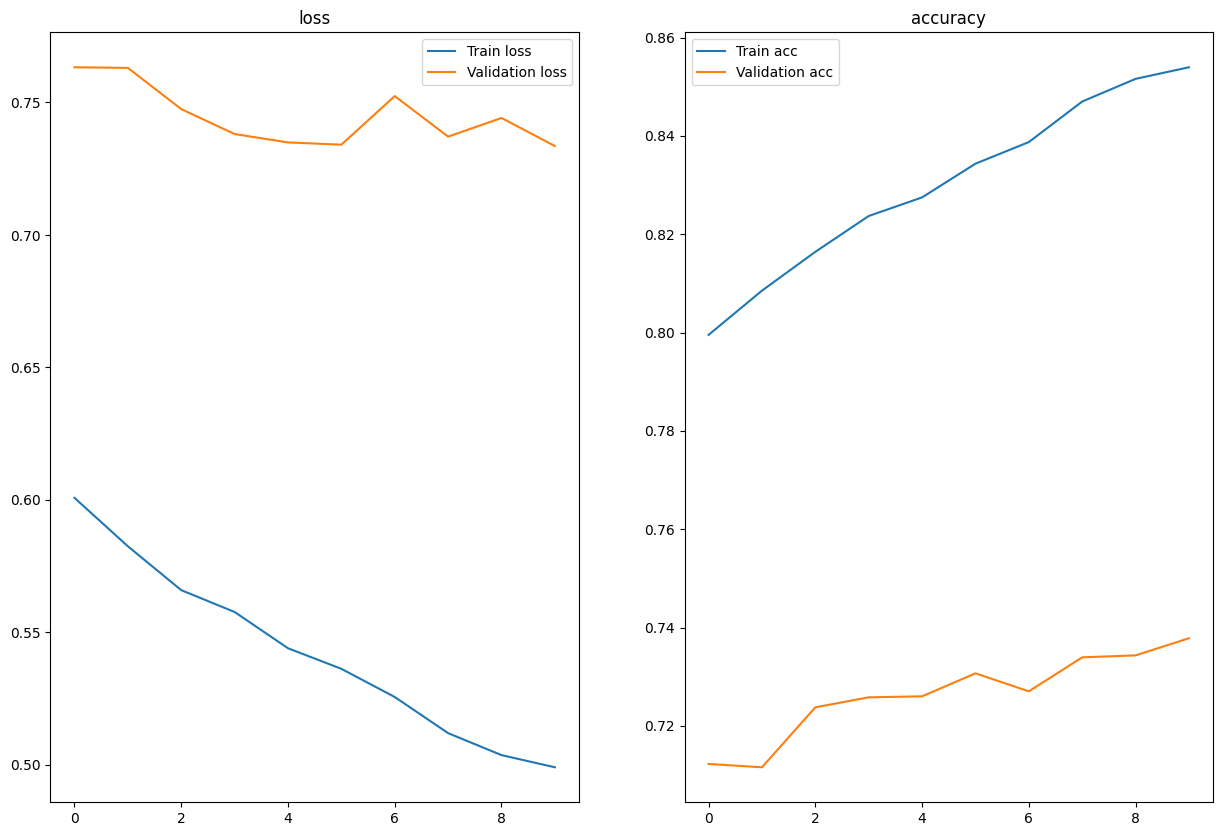

In [ ]:
plot_history(history_b3)

In [2]:
# 6. Transfer learning with EfficientB3

#7. Transfer learning with VIT

In [ ]:
from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTForImageClassification
import tensorflow as tf
import numpy as np
import shutil
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
import torch
import timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Device: {device}")
if device.type == 'cpu':
    print("⚠️ WARNING: GPU not enabled! Training will be VERY slow.")
else:
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")


🖥️ Device: cuda
✓ GPU: NVIDIA L4


In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/val'

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [ ]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['ai', 'nature']


In [ ]:
EPOCHS = 10
LR = 3e-4
WEIGHT_DECAY = 0.05

model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [ ]:
@torch.no_grad()
def evaluate():
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

In [ ]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss_sum = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * x.size(0)

    train_loss = train_loss_sum / len(train_ds)
    val_loss, val_acc = evaluate()
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

Epoch 01 | train_loss=0.6832 | val_loss=0.6621 | val_acc=0.6074
Epoch 02 | train_loss=0.6497 | val_loss=0.6184 | val_acc=0.6724
Epoch 03 | train_loss=0.6293 | val_loss=0.5946 | val_acc=0.6860
Epoch 04 | train_loss=0.6248 | val_loss=0.6187 | val_acc=0.6583
Epoch 05 | train_loss=0.6154 | val_loss=0.5710 | val_acc=0.7071
Epoch 06 | train_loss=0.5960 | val_loss=0.5837 | val_acc=0.6921
Epoch 07 | train_loss=0.5830 | val_loss=0.5532 | val_acc=0.7200
Epoch 08 | train_loss=0.6049 | val_loss=0.6380 | val_acc=0.6450
Epoch 09 | train_loss=0.6625 | val_loss=0.6886 | val_acc=0.5159
Epoch 10 | train_loss=0.6874 | val_loss=0.6865 | val_acc=0.5631


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, AutoImageProcessor
from torch.optim import AdamW

# ---- config ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

LR = 2e-5          # HF fine-tune 常用更小 lr
WEIGHT_DECAY = 0.01

train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/val'


In [ ]:
# ---- processor (get correct mean/std) ----
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
mean = processor.image_mean
std = processor.image_std

# ---- transforms ----
# 注意：ToTensor() 会把像素变成 [0,1]，这和 processor 的 rescale 等价
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# ---- datasets ----
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
for id,label in  enumerate(train_ds.classes):
  print(f"{label} | {category}")


ai | nature
nature | nature


In [ ]:
train_losses = []
train_accs = []
val_accs = []

In [ ]:
# ---- model ---
# label2id / id2label 不是必须，但强烈建议��（保存后推理更清楚）
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}
print("id2label:", id2label)
print("label2id:", label2id)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 让分类头自动重建
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

@torch.no_grad()
def evaluate():
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0

    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        outputs = model(pixel_values=x)
        logits = outputs.logits

        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)

        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

# ---- training loop ----
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(pixel_values=x)
        logits = outputs.logits

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * x.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_loss = train_loss_sum / len(train_ds)
    train_acc = train_correct / train_total
    val_loss, val_acc = evaluate()

    print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}| val_loss={val_loss:.4f} |")

id2label: {0: 'ai', 1: 'nature'}
label2id: {'ai': 0, 'nature': 1}


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([2, 768])
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([2])          

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Epoch 01 | train_acc=0.8745 | train_loss=0.2757 | val_acc=0.9327| val_loss=0.1728 |
Epoch 02 | train_acc=0.9804 | train_loss=0.0616 | val_acc=0.9310| val_loss=0.1950 |
